# Predictions based on incoming variables

## Dependencies

In [1]:
using DataFrames, DataArrays, Gadfly, Distributions, GLM

In [2]:
set_default_plot_size(985px, 400px);

## Preparing the Data

This data contains all years up to 2014

In [3]:
data = readtable("begfresh2.csv");

Load students that were admitted after 2005 and before 2015.

In [4]:
data = data[data[:ENTRYSEM] .>= 20063, :];

Transform entry year column (ex 20063 to 2006).

In [5]:
data[:ENTRYSEM] .-= 3;
data[:ENTRYSEM] ./= 10;

Number of students:

In [6]:
students = size(data)[1]

32139

## Third Semester Retention

### Training the Probit Model

Using the GLM package, a probit model is trained to give the probability that a student will still be enrolled in their third semester. The following features are used in this model:
- Composite ACT Score
- High School GPA
- Wheter the student is an American Indian
- Wheter the student is male

Exclude 2015 data from  set:

In [7]:
training_retention = data[data[:ENTRYSEM] .< 2015, :];

In [8]:
retention_model = glm(SEM03~ACTCOMP+HSGPA+AM_INDIAN+MALE, training_retention, Binomial(), ProbitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.ProbitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
              Estimate  Std.Error  z value Pr(>|z|)
(Intercept)   -1.34856  0.0654352 -20.6091   <1e-93
ACTCOMP      0.0248286 0.00231051  10.7459   <1e-26
HSGPA           0.4968  0.0201303  24.6792   <1e-99
AM_INDIAN    -0.345357  0.0356931 -9.67573   <1e-21
MALE         -0.109858  0.0171155 -6.41861    <1e-9


### Make Predictions Using the Trained Model

Using the trained model, predictions are made for each year from 2006 to 2015. The actual thrid semester retention rate is also computed for comparison.

Arrays to hold the predicted and actual retention rate for each year:

In [9]:
predicted = [];
actual = [];

Years 2006 through 2015 are looped through. For each year, the predictions are made on the subset of students who were admitted during that year.

In [10]:
year = 2006;
years = [];

In [11]:
for i=1:9
    X = data[data[:ENTRYSEM] .== year, :]
    probs = predict(retention_model, X)
    push!(predicted, mean(probs)*100)
    year != 2015 ? push!(actual, mean(X[:SEM03])*100) : nothing
    push!(years, year)
    year += 1
end

#### RMSE

In [12]:
rmse = sqrt(sum((predicted-actual).^2)) / length(years)

0.4553634221330712

#### Plot

In [13]:
theme = Theme(default_color=colorant"red")
layer_predicted = layer(x=years, y=predicted, Geom.point, Geom.line, theme);

In [14]:
theme = Theme(default_color=colorant"blue")
layer_actual = layer(x=years, y=actual, Geom.point, Geom.line, theme);

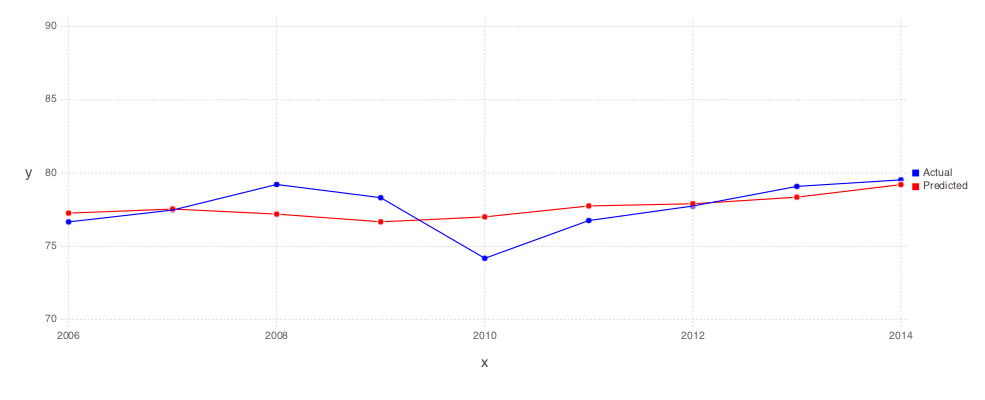

In [15]:
plot(layer_predicted, layer_actual, Coord.Cartesian(ymin=70,ymax=90), 
Guide.manual_color_key("", ["Actual", "Predicted"], ["blue", "red"]))

## 4 Year Graduation Rate

### Training the Probit Model

Using the GLM package, a probit model is trained to give the probability that a student will graduate within four years. The following features are used in this model:
- ACTCOMPSQ
- HSGPASQ
- Wheter the student is male

In [16]:
training_4year = data[data[:ENTRYSEM] .<= 2011, :];

In [17]:
gradmodel_4years = glm(GRAD4 ~ ACTCOMPSQ + HSGPASQ + MALE, training_4year, Binomial(), ProbitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.ProbitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
               Estimate  Std.Error  z value Pr(>|z|)
(Intercept)    -2.87995  0.0529779 -54.3613   <1e-99
ACTCOMPSQ    0.00151659 6.68203e-5  22.6965   <1e-99
HSGPASQ       0.0969564 0.00431302  22.4799   <1e-99
MALE          -0.243639  0.0242892 -10.0308   <1e-22


### Make Predictions Using the Trained Model

In [18]:
year = 2006;
years = [];
actual_4year = [];
predicted_4year = [];

for i=1:9
    X = data[data[:ENTRYSEM] .== year, :]
    probs = predict(gradmodel_4years, X)
    push!(predicted, mean(probs)*100)
    year <= 2011 ? push!(actual, mean(X[:GRAD4])*100) : nothing
    push!(years, year)
    year += 1
end

#### RMSE

In [19]:
rmse = sqrt(sum((predicted[1:6]-actual).^2)) / length(years)

0.4958001693781608

#### Plot

In [20]:
theme = Theme(default_color=colorant"red")
layer_predicted_4year = layer(x=years, y=predicted, Geom.point, Geom.line, theme);

In [21]:
theme = Theme(default_color=colorant"blue")
layer_actual_4year = layer(x=years[1:6], y=actual, Geom.point, Geom.line, theme);

In [37]:
plot(layer_predicted_4year, layer_actual_4year, Coord.Cartesian(ymin=0,ymax=30), 
Guide.manual_color_key("", ["Actual", "Predicted"], ["blue", "red"]))

MethodError: MethodError: `convert` has no method matching convert(::Type{DataArrays.NAtype}, ::Float64)
This may have arisen from a call to the constructor DataArrays.NAtype(...),
since type constructors fall back to convert methods.
Closest candidates are:
  call{T}(::Type{T}, ::Any)
  convert{T}(::Type{T}, !Matched::T)
  DataArrays.NAtype()

## 5 Year Graduation Rate

### Training the Probit Model

Using the GLM package, a probit model is trained to give the probability that a student graduate within five years. The following features are used in this model:
- HSGPASQ
- Wheter the student is an American Indian
- Wheter the student is male
- GTOT
- STOT
- FOUR_IN

In [23]:
training_5year = data[data[:ENTRYSEM] .<= 2010, :];

In [24]:
gradmodel_5years = glm(GRAD5 ~ HSGPASQ + MALE + AM_INDIAN + GTOT + STOT + FOUR_IN, training_5year, Binomial(), ProbitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.ProbitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
              Estimate  Std.Error  z value Pr(>|z|)
(Intercept)    -1.8103  0.0943459 -19.1879   <1e-81
HSGPASQ       0.095413 0.00627864  15.1964   <1e-51
MALE         -0.161303  0.0237398  -6.7946   <1e-10
AM_INDIAN    -0.462785  0.0548629 -8.43531   <1e-16
GTOT         0.0260418 0.00469039  5.55216    <1e-7
STOT         -0.157141  0.0132611 -11.8498   <1e-31
FOUR_IN        1.37806   0.180026  7.65477   <1e-13


### Make Predictions Using the Trained Model

In [25]:
year = 2006;
years = [];
actual = [];
predicted = [];

for i=1:9
    X = data[data[:ENTRYSEM] .== year, :]
    probs = predict(gradmodel_5years, X)
    push!(predicted, mean(probs)*100)
    year <= 2010 ? push!(actual, mean(X[:GRAD5])*100) : nothing
    push!(years, year)
    year += 1
end

#### RMSE

In [26]:
rmse = sqrt(sum((predicted[1:5]-actual).^2)) / length(years)

NA

#### Plot

In [27]:
theme = Theme(default_color=colorant"red")
layer_predicted = layer(x=years, y=predicted, Geom.point, Geom.line, theme);

In [28]:
theme = Theme(default_color=colorant"blue")
layer_actual = layer(x=years[1:5], y=actual, Geom.point, Geom.line, theme);

In [29]:
plot(layer_predicted, layer_actual, Coord.Cartesian(ymin=0,ymax=90), 
Guide.manual_color_key("", ["Actual", "Predicted"], ["blue", "red"]))

MethodError: MethodError: `convert` has no method matching convert(::Type{DataArrays.NAtype}, ::Float64)
This may have arisen from a call to the constructor DataArrays.NAtype(...),
since type constructors fall back to convert methods.
Closest candidates are:
  call{T}(::Type{T}, ::Any)
  convert{T}(::Type{T}, !Matched::T)
  DataArrays.NAtype()

## 6 Year Graduation Rate

### Training the Probit Model

Using the GLM package, a probit model is trained to give the probability that a student will graduate within 6 years. The following features are used in this model:
- Composite ACT Score
- ACTCOMPSQ
- FIVE_IN

In [30]:
training_6year = data[data[:ENTRYSEM] .<= 2009, :];

In [31]:
gradmodel_6years = glm(GRAD6 ~ ACTCOMP + ACTCOMPSQ + FIVE_IN, training_6year, Binomial(), ProbitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.ProbitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}:

Coefficients:
                Estimate   Std.Error  z value Pr(>|z|)
(Intercept)     -1.97707    0.300471 -6.57991   <1e-10
ACTCOMP        0.0894003   0.0270701  3.30255   0.0010
ACTCOMPSQ    -0.00211207 0.000593861 -3.55651   0.0004
FIVE_IN          2.71902    0.087731  30.9928   <1e-99


### Make Predictions Using the Trained Model

In [32]:
year = 2006;
years = [];
actual = [];
predicted = [];

for i=1:9
    X = data[data[:ENTRYSEM] .== year, :]
    probs = predict(gradmodel_6years, X)
    push!(predicted, mean(probs)*100)
    year <= 2009 ? push!(actual, mean(X[:GRAD5])*100) : nothing
    push!(years, year)
    year += 1
end

#### RMSE

In [33]:
rmse = sqrt(sum((predicted[1:4]-actual).^2)) / length(years)

NA

#### Plot

In [34]:
theme = Theme(default_color=colorant"red")
layer_predicted = layer(x=years, y=predicted, Geom.point, Geom.line, theme);

In [35]:
theme = Theme(default_color=colorant"blue")
layer_actual = layer(x=years[1:4], y=actual, Geom.point, Geom.line, theme);

In [36]:
plot(layer_predicted, layer_actual, Coord.Cartesian(ymin=0,ymax=90), 
Guide.manual_color_key("", ["Actual", "Predicted"], ["blue", "red"]))

MethodError: MethodError: `convert` has no method matching convert(::Type{DataArrays.NAtype}, ::Float64)
This may have arisen from a call to the constructor DataArrays.NAtype(...),
since type constructors fall back to convert methods.
Closest candidates are:
  call{T}(::Type{T}, ::Any)
  convert{T}(::Type{T}, !Matched::T)
  DataArrays.NAtype()